# Corona Statistics Scandinavia

## Import modules

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

import plotly.graph_objects as go
import plotly.express as px

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.subplots import make_subplots

## Retrieve data from Our World In Data
https://ourworldindata.org/

In [ ]:
url = "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv"

df = pd.read_csv(url, parse_dates=True)
df['date'] = pd.to_datetime(df['date'])

## Create Data Frame for Scandinavia

In [ ]:
scandic = ["Sweden", "Norway", "Denmark"]
df_scandinavia = df[df["location"].isin(scandic)]

## Custom colors

In [ ]:
colors = {
    "Sweden": ["green", "green"],
    "Norway": ["blue", "lightblue"],
    "Denmark": ["red", "tomato"]
    }

## Function to plot the data

In [ ]:
# Function to make a Plotly plot
def plot_data(df, countries, plot_variable, start_date, end_date, plot_type="bar", mav=None, colors=None, mean_line=None):
    # Default color list 
    COLOR_LIST = ["green", "blue", "red", "purple", "black", "yellow"]
    
    # Function to create a dictionary of colors
    def make_color_dict():
        colors = {}
        for i, c in enumerate(countries):
            col_idx = i if i < len(COLOR_LIST) else i % (len(COLOR_LIST))
            colors[c] = [COLOR_LIST[col_idx], COLOR_LIST[col_idx]]
        return colors


    # Create a figure
    fig = go.Figure()

    # Create list of countries if list not passed
    if not isinstance(countries, list):
        countries = [countries]
    
    # Check if custom colors is passed. Otherwise create default color dictionary
    if not colors:
        colors = make_color_dict()

    # Create plot for each country passed
    for c_idx, country in enumerate(countries):

        df_to_plot = df.copy()

        # Get data for selected countries and dates
        df_to_plot = df_to_plot[df_to_plot["location"] == country]
        df_to_plot = df_to_plot[(df_to_plot["date"] >= start_date) & (df_to_plot["date"] <= end_date)]

        # Plot line if plot type is line 
        if plot_type.lower() == "line":
            c_plot = go.Scatter(
            x = df_to_plot["date"],
            y = df_to_plot[plot_variable],
            line = {"color": colors[country][0]},
            name = country,
            )

            fig.add_trace(c_plot)
        
        # Plot bar if plot type is bar
        if plot_type.lower() == "bar":
            c_plot = go.Bar(
            x = df_to_plot["date"],
            y = df_to_plot[plot_variable],
            marker_color = colors[country][0],
            name = country,
            )

            fig.add_trace(c_plot)
        
        # Plot moving average if passed
        if mav:
            if len(mav) > 1:
                MAV_COLORS = sns.color_palette("gist_ncar_r", len(mav) * len(countries))
                def_mav_colors = True
            else:
                def_mav_colors = False

            for i, m in enumerate(mav):
                # Calculate rolling average
                df_to_plot[f"{m}_avg"] = df_to_plot[plot_variable].rolling(m).mean()
                
                if def_mav_colors:
                    color = f"rgb{MAV_COLORS[(i + c_idx + countries.index(country)) % len(MAV_COLORS)]}"
                else:
                    color = colors[country][1]

                # print(i, (i + c_idx + countries.index(country)) % len(MAV_COLORS))

                mav_plot = go.Scatter(
                    x = df_to_plot["date"],
                    y = df_to_plot[f"{m}_avg"],
                    line = {"color": color, "dash": "dot"},
                    name = f"{country} average {m} days"
                )
                
                fig.add_trace(mav_plot)

        # Plot mean line if True
        if mean_line:
            mv = df_to_plot[plot_variable].mean()
            mpl = go.Scatter(
                x = df_to_plot["date"],
                y = [mv] * len(df_to_plot),
                line = {"width": 3, "dash": "dash", "color": colors[country][0]},
                opacity = .3,
                name = f"{country} Mean"
            )
            fig.add_trace(mpl)
            

        
    # Set the title for the plot
    if set(countries) == set(["Denmark", "Sweden", "Norway"]):
        country_title = "Scandinavia"
    else:
        country_title = ", ".join(countries)

    title_str = go.layout.Title(
        text=f"Corona Virus - {' '.join(plot_variable.split('_')).title()}<br><sup>{country_title} </sup>",
        xref="paper",
        x=0
    )
        
    # Update the figure with the plot traces
    fig.update_layout(
        width=1000,
        height=600,
        showlegend=True,
        title=title_str,
        xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text="Date"
            )
        ))

    # Show the plot
    iplot(fig)

## Plots

In [ ]:
plot_data(df_scandinavia, ["Sweden", "Norway"], "new_cases_per_million", "2021-10-01", "2022-01-15", "bar", [7, 30], colors=None)

In [ ]:
plot_data(df, ["Sweden", "Norway"], "reproduction_rate", "2020-03-01", "2022-01-15", plot_type="line", mav=[60], colors=None, mean_line=True)

In [ ]:
plot_data(df_scandinavia, scandic, "total_deaths_per_million", "2020-03-01", "2022-01-15", plot_type="line", mav=None, colors=None)

In [ ]:
plot_data(df_scandinavia, scandic, "new_cases", "2021-01-01", "2022-01-15", plot_type="bar", mav=[7])

## Plots using Seaborn instead of Plotly

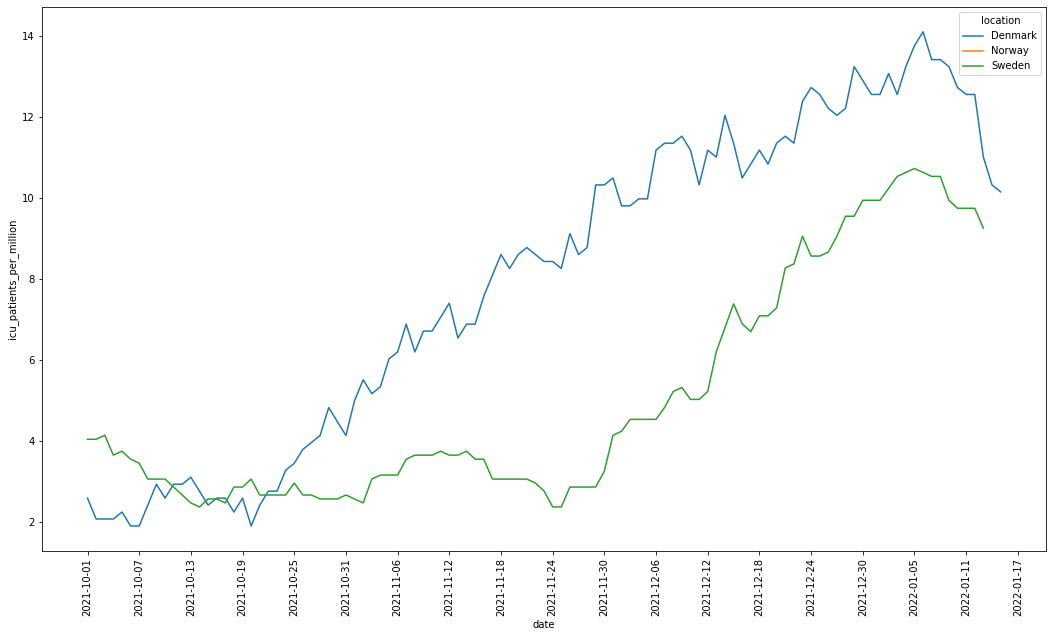

In [ ]:
fig, ax = plt.subplots(figsize=(18,10))

sns.lineplot(x="date", y="icu_patients_per_million", data=df_scandinavia[df_scandinavia["date"] >= "2021-10-01"], hue="location", ax=ax)

ax.xaxis.set_major_locator(ticker.MaxNLocator(20))
# ax.xaxis.set_major_locator(ticker.AutoLocator())
# ax.xaxis.set_major_locator(ticker.MultipleLocator(15))

plt.xticks(rotation=90)


plt.show()